In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 26s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_44.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(44, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.291030,94.644244,92.757506,92.470771,95.133177,93.859346
공시지가(만원),79.592887,80.152134,77.270997,80.303432,77.470295,78.957949
year_linear,64.068830,64.381504,63.091204,64.391707,66.054345,64.397518
건축년도,50.370523,47.868151,48.426021,50.904730,49.060384,49.325962
전용면적,38.223000,41.397272,38.293735,41.608660,34.694602,38.843454


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.291030,94.644244,92.757506,92.470771,95.133177,93.859346
공시지가(만원),79.592887,80.152134,77.270997,80.303432,77.470295,78.957949
year_linear,64.068830,64.381504,63.091204,64.391707,66.054345,64.397518
건축년도,50.370523,47.868151,48.426021,50.904730,49.060384,49.325962
전용면적,38.223000,41.397272,38.293735,41.608660,34.694602,38.843454
ynorm,32.149531,32.103976,31.932168,32.627360,30.368998,31.836407
xy,22.432195,21.447759,22.623715,23.049658,20.943867,22.099439
x_2nd,19.286333,17.477047,20.057481,19.946042,19.248369,19.203055
주건축물수,13.874715,12.917700,13.021904,12.950650,13.081337,13.169261
층mean,10.782102,11.753199,10.132729,11.425666,11.522294,11.123198


In [14]:
top_43_df = shap_summary_df.iloc[:43,:]
print(top_43_df.shape)

(43, 6)


In [15]:
top_43_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.291030,94.644244,92.757506,92.470771,95.133177,93.859346
공시지가(만원),79.592887,80.152134,77.270997,80.303432,77.470295,78.957949
year_linear,64.068830,64.381504,63.091204,64.391707,66.054345,64.397518
건축년도,50.370523,47.868151,48.426021,50.904730,49.060384,49.325962
전용면적,38.223000,41.397272,38.293735,41.608660,34.694602,38.843454


In [16]:
top_43_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지구단위계획구역,3.207514,3.288076,2.933521,3.059645,3.217297,3.141210
부속건축물수,2.335279,2.990293,2.146013,4.247984,2.602227,2.864359
가축사육제한구역,2.991848,2.775462,2.742598,2.466369,2.669657,2.729187
도로접면,3.131190,2.491535,2.297608,2.740477,2.545172,2.641196
지붕_평지붕_fraction,2.772428,3.074691,2.291217,2.501222,2.559651,2.639842
지형높이,2.516445,2.448227,2.420618,2.451755,2.325945,2.432598
건물나이,2.344443,2.302801,2.334207,2.289130,2.488438,2.351804
(한강)폐기물매립시설_설치제한지역,2.063420,2.548997,2.405365,2.313119,2.223843,2.310949
부속건축물면적,2.419989,2.088083,2.265527,1.804423,2.188449,2.153294
층min,2.269146,2.010431,2.098644,2.014136,2.285732,2.135618


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_43_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 48)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,아파트지구,xnorm,호수대비연면적,호수대비부속건축물면적,옥내자주식대수,층,총호수,y_2nd,호수대비주차수,용도지역명1,층norm,지구단위계획구역,부속건축물수,가축사육제한구역,도로접면,지붕_평지붕_fraction,지형높이,건물나이,(한강)폐기물매립시설_설치제한지역,부속건축물면적,층min,month_sin,옥외자주식대수,공원,지형형상,y_cos,x_sin,y_sin,x_cos,제3종일반주거지역,제1종지구단위계획구역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,2,54.0,4.094180e+07,0.0,0,0.222222,0,0.0,0,0,1.0,0,0,0,0.0,9.0,-0.866025,0.0,0,0,0.390815,-0.364267,-0.920469,0.931294,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,2,54.0,4.094180e+07,0.0,0,0.222222,0,0.0,0,0,1.0,0,0,0,0.0,9.0,-0.500000,0.0,0,0,0.390815,-0.364267,-0.920469,0.931294,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,4,54.0,4.094180e+07,0.0,0,0.444444,0,0.0,0,0,1.0,0,0,0,0.0,9.0,0.000000,0.0,0,0,0.390815,-0.364267,-0.920469,0.931294,0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,9,54.0,4.094180e+07,0.0,0,1.000000,0,0.0,0,0,1.0,0,0,0,0.0,9.0,0.866025,0.0,0,0,0.390815,-0.364267,-0.920469,0.931294,0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,1,54.0,4.094180e+07,0.0,0,0.111111,0,0.0,0,0,1.0,0,0,0,0.0,9.0,-0.866025,0.0,0,0,0.390815,-0.364267,-0.920469,0.931294,0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

14

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 43)
y dist plot


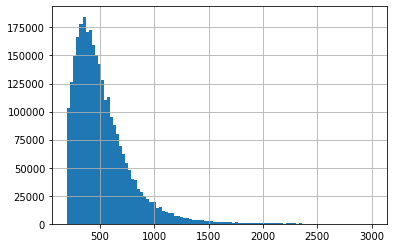

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5924
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 43


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5813
[100]	valid_0's huber: 64.7539
[150]	valid_0's huber: 58.5993
[200]	valid_0's huber: 54.9144
[250]	valid_0's huber: 52.4199
[300]	valid_0's huber: 50.7676
[350]	valid_0's huber: 49.4651
[400]	valid_0's huber: 48.3908
[450]	valid_0's huber: 47.3609
[500]	valid_0's huber: 46.5669
[550]	valid_0's huber: 45.8648
[600]	valid_0's huber: 45.2007
[650]	valid_0's huber: 44.5851
[700]	valid_0's huber: 44.0519
[750]	valid_0's huber: 43.631
[800]	valid_0's huber: 43.1677
[850]	valid_0's huber: 42.7778
[900]	valid_0's huber: 42.464
[950]	valid_0's huber: 42.1625
[1000]	valid_0's huber: 41.8212
[1050]	valid_0's huber: 41.532
[1100]	valid_0's huber: 41.2492
[1150]	valid_0's huber: 41.0001
[1200]	valid_0's huber: 40.7734
[1250]	valid_0's huber: 40.5696
[1300]	valid_0's huber: 40.3561
[1350]	valid_0's huber: 40.1643
[1400]	valid_0's huber: 39.998
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


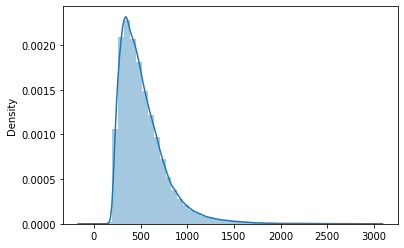

Fold 0 end
Fold 1 start
(2926581, 43)
y dist plot


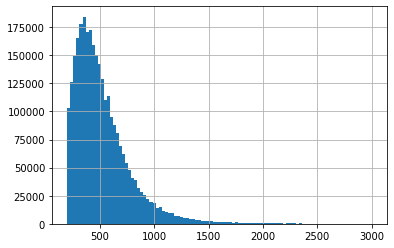

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5925
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 43


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 64.9314
[150]	valid_0's huber: 58.6719
[200]	valid_0's huber: 55.0619
[250]	valid_0's huber: 52.6568
[300]	valid_0's huber: 50.8601
[350]	valid_0's huber: 49.4224
[400]	valid_0's huber: 48.3963
[450]	valid_0's huber: 47.4244
[500]	valid_0's huber: 46.5828
[550]	valid_0's huber: 46.0199
[600]	valid_0's huber: 45.3787
[650]	valid_0's huber: 44.8136
[700]	valid_0's huber: 44.2978
[750]	valid_0's huber: 43.7663
[800]	valid_0's huber: 43.3152
[850]	valid_0's huber: 42.903
[900]	valid_0's huber: 42.5568
[950]	valid_0's huber: 42.2298
[1000]	valid_0's huber: 41.9312
[1050]	valid_0's huber: 41.5907
[1100]	valid_0's huber: 41.3039
[1150]	valid_0's huber: 41.0684
[1200]	valid_0's huber: 40.8253
[1250]	valid_0's huber: 40.5932
[1300]	valid_0's huber: 40.3561
[1350]	valid_0's huber: 40.1347
[1400]	valid_0's huber: 39.9503
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


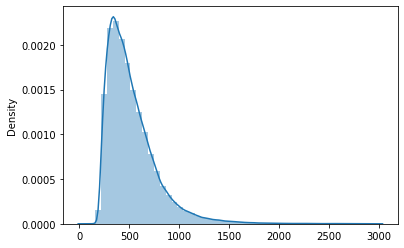

Fold 1 end
Fold 2 start
(2926581, 43)
y dist plot


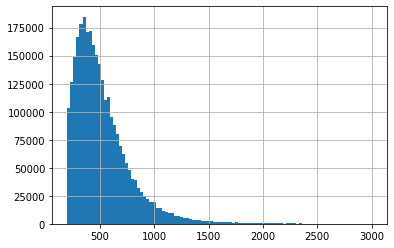

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5927
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 43


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.6549
[150]	valid_0's huber: 58.6447
[200]	valid_0's huber: 55.0791
[250]	valid_0's huber: 52.5705
[300]	valid_0's huber: 50.8708
[350]	valid_0's huber: 49.5512
[400]	valid_0's huber: 48.4768
[450]	valid_0's huber: 47.4505
[500]	valid_0's huber: 46.6075
[550]	valid_0's huber: 45.8904
[600]	valid_0's huber: 45.2329
[650]	valid_0's huber: 44.6338
[700]	valid_0's huber: 44.1424
[750]	valid_0's huber: 43.7314
[800]	valid_0's huber: 43.3346
[850]	valid_0's huber: 42.9301
[900]	valid_0's huber: 42.5794
[950]	valid_0's huber: 42.2435
[1000]	valid_0's huber: 41.9019
[1050]	valid_0's huber: 41.5508
[1100]	valid_0's huber: 41.3156
[1150]	valid_0's huber: 41.0881
[1200]	valid_0's huber: 40.8064
[1250]	valid_0's huber: 40.5839
[1300]	valid_0's huber: 40.3667
[1350]	valid_0's huber: 40.1688
[1400]	valid_0's huber: 39.953
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


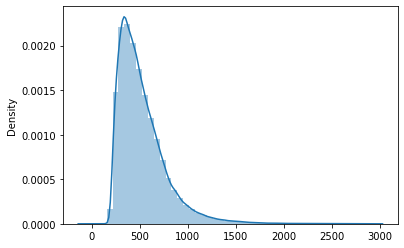

Fold 2 end
Fold 3 start
(2926581, 43)
y dist plot


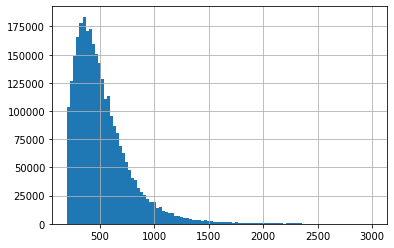

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5921
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 43


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7242
[150]	valid_0's huber: 58.7164
[200]	valid_0's huber: 55.1567
[250]	valid_0's huber: 52.6497
[300]	valid_0's huber: 50.8549
[350]	valid_0's huber: 49.5659
[400]	valid_0's huber: 48.531
[450]	valid_0's huber: 47.5613
[500]	valid_0's huber: 46.7347
[550]	valid_0's huber: 46.0381
[600]	valid_0's huber: 45.4402
[650]	valid_0's huber: 44.8562
[700]	valid_0's huber: 44.2684
[750]	valid_0's huber: 43.7326
[800]	valid_0's huber: 43.3034
[850]	valid_0's huber: 42.9044
[900]	valid_0's huber: 42.5056
[950]	valid_0's huber: 42.178
[1000]	valid_0's huber: 41.8523
[1050]	valid_0's huber: 41.5504
[1100]	valid_0's huber: 41.2541
[1150]	valid_0's huber: 40.9853
[1200]	valid_0's huber: 40.7655
[1250]	valid_0's huber: 40.5306
[1300]	valid_0's huber: 40.2929
[1350]	valid_0's huber: 40.0711
[1400]	valid_0's huber: 39.8492
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


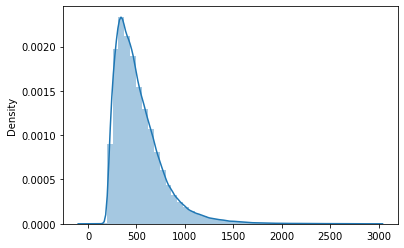

Fold 3 end
Fold 4 start
(2926581, 43)
y dist plot


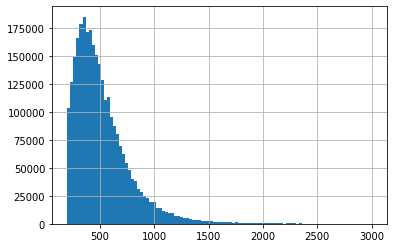

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5922
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 43


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.7985
[150]	valid_0's huber: 58.6738
[200]	valid_0's huber: 55.1807
[250]	valid_0's huber: 52.659
[300]	valid_0's huber: 50.8551
[350]	valid_0's huber: 49.5282
[400]	valid_0's huber: 48.4582
[450]	valid_0's huber: 47.5404
[500]	valid_0's huber: 46.7781
[550]	valid_0's huber: 46.0444
[600]	valid_0's huber: 45.445
[650]	valid_0's huber: 44.8503
[700]	valid_0's huber: 44.3252
[750]	valid_0's huber: 43.8812
[800]	valid_0's huber: 43.4182
[850]	valid_0's huber: 43.0312
[900]	valid_0's huber: 42.6957
[950]	valid_0's huber: 42.338
[1000]	valid_0's huber: 41.9918
[1050]	valid_0's huber: 41.666
[1100]	valid_0's huber: 41.4111
[1150]	valid_0's huber: 41.1515
[1200]	valid_0's huber: 40.944
[1250]	valid_0's huber: 40.6921
[1300]	valid_0's huber: 40.4779
[1350]	valid_0's huber: 40.2896
[1400]	valid_0's huber: 40.0872
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


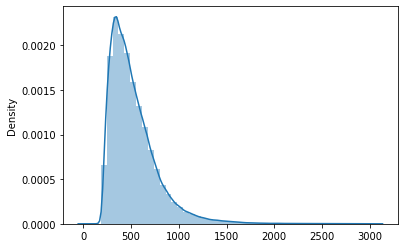

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_43_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.725131433881

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_43.csv')

In [33]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.585896,93.262382,92.376886,93.594862,94.408425,93.445690
공시지가(만원),76.880842,75.533711,76.290929,75.605703,79.045383,76.671314
year_linear,64.099953,63.704039,63.705342,67.273280,62.744964,64.305516
건축년도,48.728769,48.516957,48.006189,51.584938,48.915165,49.150404
전용면적,37.670910,38.650777,38.866730,41.297803,37.709567,38.839158
ynorm,31.204228,29.965851,31.785528,30.609470,30.148801,30.742776
xy,22.165540,21.232864,22.343831,22.979876,20.984277,21.941278
x_2nd,19.403770,19.470686,18.247213,20.904904,19.360753,19.477465
주건축물수,14.282854,13.331193,14.810889,13.414062,13.577355,13.883270
층mean,11.274431,10.356003,11.556881,10.722629,12.155694,11.213127


In [34]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
month_sin,2.237298,2.068930,2.158602,2.305537,2.185180,2.191109
옥외자주식대수,2.459698,2.240475,2.139376,2.020883,2.231606,2.218408
공원,2.072264,2.004137,1.983738,2.387939,1.830549,2.055725
지형형상,1.388558,1.288330,1.452241,1.506708,1.372798,1.401727
y_cos,1.269254,1.431791,1.254057,1.378647,1.184130,1.303576
x_sin,1.274057,1.295498,1.131065,1.342338,1.533397,1.315271
y_sin,1.190515,1.353036,1.217607,1.277703,1.189155,1.245603
x_cos,1.084450,1.270241,1.143417,1.188036,1.497520,1.236733
제3종일반주거지역,1.266038,1.088962,1.273584,1.130364,0.987740,1.149338
제1종지구단위계획구역,1.139086,1.004625,0.856514,1.044963,1.049230,1.018884


In [35]:
#